# ***Projet IA***

# Importation des données

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split



# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

#rn
from tensorflow import keras


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analyse

In [3]:
#LOADING DATA
df_train=pd.read_excel('drive/My Drive/Colab Notebooks/Data-FakeRealCOVID.xlsx')
print(df_train.shape)
df_train.head()
df_train

(6420, 3)


,id,tweet,label
0,1.0,The CDC currently reports 99031 deaths. In gen...,real
1,2.0,States reported 1121 deaths a small rise from ...,real
2,3.0,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4.0,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5.0,Populous states can generate large case counts...,real
...,...,...,...
6415,6416.0,A tiger tested positive for COVID-19 please st...,fake
6416,6417.0,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418.0,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419.0,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


In [4]:
#UN PEU D'ANALYSE 

print(df_train.columns.tolist())

['id', 'tweet', 'label']


real    3360
fake    3060
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


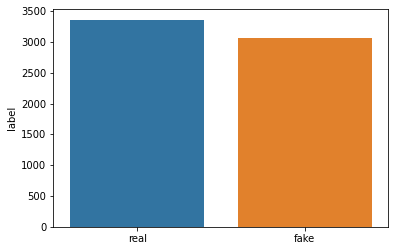

In [5]:
# CLASS DISTRIBUTION
x=df_train['label'].value_counts()
print(x)
sns.barplot(x.index,x) ##representation des diff variables du label real/fake


In [6]:
#Missing values
df_train.isna().sum()


id       0
tweet    0
label    0
dtype: int64

In [7]:
#WORD-COUNT (return average)
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['label']=='real']['word_count'].mean()) #real tweets
print(df_train[df_train['label']=='fake']['word_count'].mean()) #fake tweets
#real tweets are more wordy than the fake ones


31.676488095238096
21.865359477124183


In [8]:
#CHARACTER-COUNT(return average)
df_train['char_count'] = df_train['tweet'].apply(lambda x: len(str(x)))
print(df_train[df_train['label']=='real']['char_count'].mean()) #real tweets
print(df_train[df_train['label']=='fake']['char_count'].mean()) #fake tweets
#real tweets are longer than the fake ones


215.06160714285716
144.89019607843136


In [9]:
#UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['tweet'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['label']=='real']['unique_word_count'].mean()) #real tweets
print(df_train[df_train['label']=='fake']['unique_word_count'].mean()) #fake tweets


28.428571428571427
19.99640522875817


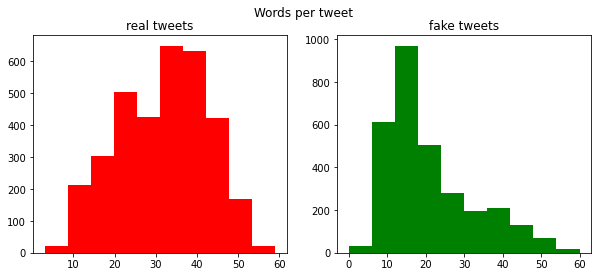

In [10]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['label']=='real']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('real tweets')
train_words=df_train[df_train['label']=='fake']['word_count']
ax2.hist(train_words,color='green' , range=(0,60) )
ax2.set_title('fake tweets')
fig.suptitle('Words per tweet')
plt.show()


# PHASE DE PRE-PROCESSING

## Emoji

In [11]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

## Convert to lowercase and remove punctuations and characters and strip..

In [12]:

def preprocess(text):
    text = text.lower() #lowercase text
    text = text.strip()  #get rid of leading/trailing whitespace supprime les espaces au debut et a la fin de la phrase
    text = re.sub("https?:\/\/.*[\r\n]*", "", text) #liens
    text = re.sub("@\S+", "",text) #mentions#####
    text = re.sub("#\S+", "", text) #hastags#####
    text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub("[0-9]\S+", "", text) #numbers+letters#######
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...) remove numbers between []
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits remove numbers found in string
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    text = re.sub("corona\S+", "covid",text) #derivés de covid######

    return text


## Stopword removal

In [13]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


## Stemming

In [14]:
#(slicing the end or the beginning of words with the intention of removing affixes(prefix/suffix))
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)


## Lemmatization

In [15]:
#(reducing the word to its base form)

# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [16]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)



##1.5. Final processing

In [17]:
def finalpreprocess(string):
    return lemmatizer(preprocess(deEmojify(stopword(string))))


In [22]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [23]:
## mettre real fake dans 0 1 pour le RN
df_train['redif_label'] = df_train['label']
df_train['redif_label']=df_train['redif_label'].replace('real', 1)
df_train['redif_label']=df_train['redif_label'].replace('fake', 0)
df_train.head()

,id,tweet,label,clean_tweet,redif_label
0,1.0,The CDC currently reports 99031 deaths. In gen...,real,the cdc currently report death in general disc...,1
1,2.0,States reported 1121 deaths a small rise from ...,real,state report death small rise last tuesday sou...,1
2,3.0,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost use pandemic ...,0
3,4.0,#IndiaFightsCorona: We have 1524 #COVID testin...,real,we test laboratory india august test do dg,1
4,5.0,Populous states can generate large case counts...,real,populous state generate large case count look ...,1


# PHASE DE VECTORISATION

## Séparation des données

In [24]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION 
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_tweet"],
                                                  df_train["redif_label"],
                                                  test_size=0.2,
                                                  shuffle=True)

## Bag of words TF-IDF

In [25]:
#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_fit = tfidf_vectorizer.fit(X_train)
X_train_vectors_tfidf=X_train_vectors_fit.transform(X_train)
# Only transform x_test (not fit and transform)
#X_val_vectors_fit = tfidf_vectorizer.fit(X_val) 
#val_tokens=X_val_vectors_fit.get_feature_names_out()
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)
#Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible

In [26]:
shape=X_train_vectors_tfidf.shape[1]
shape

8087

# PHASE D'APPRENTISSAGE

## Création du RN

In [27]:
def get_model(shape):
    model=keras.models.Sequential()
    model.add(keras.layers.Dense(units=shape/10, activation='relu', kernel_initializer='uniform', input_dim=shape))
    model.add(keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))
    model.compile(optimizer='adam',
                 loss='mse',
                 metrics=['binary_accuracy'])
    return model

In [28]:
model=get_model(shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 808)               6535104   
                                                                 
 dense_1 (Dense)             (None, 1)                 809       
                                                                 
Total params: 6,535,913
Trainable params: 6,535,913
Non-trainable params: 0
_________________________________________________________________


## Entrainement

In [29]:
history=model.fit(X_train_vectors_tfidf.toarray(), y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_val_vectors_tfidf.toarray(), y_val))

Epoch 1/10
6/6 [==============================] - 4s 481ms/step - loss: 0.2444 - binary_accuracy: 0.6232 - val_loss: 0.2329 - val_binary_accuracy: 0.7033
Epoch 2/10
6/6 [==============================] - 3s 443ms/step - loss: 0.2224 - binary_accuracy: 0.8032 - val_loss: 0.2091 - val_binary_accuracy: 0.7812
Epoch 3/10
6/6 [==============================] - 3s 451ms/step - loss: 0.1917 - binary_accuracy: 0.8828 - val_loss: 0.1781 - val_binary_accuracy: 0.8458
Epoch 4/10
6/6 [==============================] - 3s 441ms/step - loss: 0.1545 - binary_accuracy: 0.9188 - val_loss: 0.1451 - val_binary_accuracy: 0.8738
Epoch 5/10
6/6 [==============================] - 3s 443ms/step - loss: 0.1168 - binary_accuracy: 0.9422 - val_loss: 0.1154 - val_binary_accuracy: 0.8964
Epoch 6/10
6/6 [==============================] - 3s 445ms/step - loss: 0.0848 - binary_accuracy: 0.9546 - val_loss: 0.0939 - val_binary_accuracy: 0.9104
Epoch 7/10
6/6 [==============================] - 3s 439ms/step - loss: 0.06

## Evaluation des performances

In [30]:
score=model.evaluate(X_val_vectors_tfidf.toarray(), y_val, verbose=1)
score_train=model.evaluate(X_train_vectors_tfidf.toarray(), y_train, verbose=1)
print('x_train/loss       : {:5.4f}'.format(score_train[0]))
print('x_train/accuracy   : {:5.4f}'.format(score_train[1]))
print('x_test/loss       : {:5.4f}'.format(score[0]))
print('x_test/accuracy   : {:5.4f}'.format(score[1]))

161/161 [==============================] - 2s 14ms/step - loss: 0.0250 - binary_accuracy: 0.9813
x_train/loss       : 0.0250
x_train/accuracy   : 0.9813
x_test/loss       : 0.0659
x_test/accuracy   : 0.9143


In [31]:
df_h=pd.DataFrame(data=history.history)
df_h

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.244409,0.623248,0.232926,0.703271
1,0.222370,0.803154,0.209114,0.781153
2,0.191675,0.882788,0.178148,0.845794
3,0.154532,0.918808,0.145130,0.873832
4,0.116802,0.942173,0.115374,0.896417
5,0.084835,0.954634,0.093878,0.910436
6,0.062129,0.960280,0.080705,0.916667
7,0.046788,0.967095,0.073035,0.917445
8,0.036266,0.973910,0.068681,0.917445
9,0.028996,0.978388,0.065874,0.914330


## Prédiction données de test

In [32]:
prediction=model.predict(X_val_vectors_tfidf.toarray())


41/41 [==============================] - 1s 14ms/step


In [33]:
print(prediction)

[[0.15995479]
 [0.4019822 ]
 [0.7057677 ]
 ...
 [0.01812977]
 [0.07999831]
 [0.08331309]]


In [34]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_val, prediction.round())
print('Confusion Matrix:')
print(confusion_matrix(y_val, prediction.round()))

Confusion Matrix:
[[559  55]
 [ 55 615]]


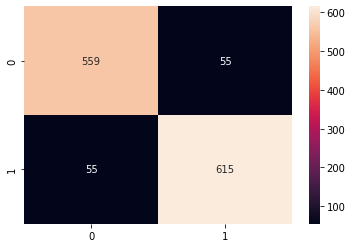

In [35]:
DetaFrame_cm = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True, fmt='d')
plt.show()

In [36]:
y_val=y_val.replace(1,'real')
y_val=y_val.replace(0,'fake')

In [37]:
#print(f"prediction: {prediction.round()}")
redif_prediction=['']*len(prediction)
for i in range(len(prediction)):
  if prediction.round()[i]==1:
    redif_prediction[i]='real'
  else:
    redif_prediction[i]='fake'
#print(f"prediction categorie: {redif_prediction}")
#print(f"reality: {y_val}")


In [38]:
redif_prediction=['test']*len(prediction)
for i in range(len(prediction)):
  if prediction.round()[i]==1:
    redif_prediction[i]='real'
  else:
    redif_prediction[i]='fake'
#print(f"prediction: {redif_prediction}")


# INTERFACE GRAPHIQUE

In [42]:
#!pip install gradio

In [40]:
def predict_text(tweet):
  redif_predict=''
  texte=finalpreprocess(tweet)
  s=pd.Series(texte)
  s_tdidf=tfidf_vectorizer.transform(s)
  predict=model.predict(s_tdidf.toarray())
  if predict.round()==1:
    redif_predict='real'
  else:
    redif_predict='fake'
  return redif_predict


In [41]:
import gradio as gr
gr.Interface(predict_text, "textbox", outputs=gr.outputs.Textbox()).launch()


/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://29040.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f04b8c48610>,
 'http://127.0.0.1:7860/',
 'https://29040.gradio.app')